In [43]:
import os
import pandas as pd

In [44]:
image_dir = r"Dataset_github"

In [45]:
image_lst = []
for image_class in os.listdir(image_dir):    
    # print(image_class)
    image_class_path = os.path.join(image_dir, image_class)
    if os.path.isdir(image_class_path):
        images = os.listdir(image_class_path)
        images = [os.path.join(os.path.split(image_class_path)[-1], img) for img in images]
        image_lst.extend(images)

In [46]:
df = pd.DataFrame(image_lst, columns=['image:FILE'])
df['category'] = 0

In [47]:
df

,image:FILE,category
0,aloevera\aloevera800.jpg,0
1,aloevera\aloevera801.jpg,0
2,aloevera\aloevera802.jpg,0
3,aloevera\aloevera803.jpg,0
4,aloevera\aloevera804.jpg,0
...,...,...
295,watermelon\watermelon805.jpg,0
296,watermelon\watermelon806.jpg,0
297,watermelon\watermelon807.jpg,0
298,watermelon\watermelon808.jpg,0


In [48]:
import sklearn.model_selection as train_test_split

In [49]:
train_df, val_df = train_test_split.train_test_split(df, test_size=0.2, random_state=42, stratify=df['category'])
train_df, test_df = train_test_split.train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['category'])

In [50]:
train_df.to_csv(r"Dataset_github/train.csv", index=False)
val_df.to_csv(r"Dataset_github/val.csv", index=False)
test_df.to_csv(r"Dataset_github/test.csv", index=False)

In [3]:
import os
from copy import deepcopy
import sys
# import numpy as np
import pandas as pd
import pickle
import json
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.jit as jit
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import mlflow
from mlflow.artifacts import download_artifacts

In [2]:
model = torch.jit.load(r"ghost_netv1.pt")

In [14]:
inference_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [6]:
with open(r"processed_data\preprocess_artifact.pkl", "rb") as f:
    artifact = pickle.load(f) 

In [8]:
le = artifact["label_encoder"]

In [9]:
test_df = pd.read_csv(r"validation_data\test.csv")

In [10]:
test_df['label'] = le.transform(test_df['class'])

In [11]:
class CustomDataset(Dataset):
            def __init__(self, path_label, transform=None):
                self.path_label = path_label
                self.transform = transform

            def __len__(self):
                return len(self.path_label)

            def __getitem__(self, idx):
                path, label = self.path_label[idx]
                img = Image.open(path).convert('RGB')

                if self.transform is not None:
                    img = self.transform(img)

                label = torch.tensor(label, dtype=torch.long)  #LongTensor
                return img, label

In [12]:
def create_path_label_list(df):
            path_label_list = []
            for _, row in df.iterrows():
                path = row['file_path']
                label = row['label']
                path_label_list.append((path, label))
            return path_label_list

In [ ]:
test_dataset = CustomDataset(create_path_label_list(test_df), transform=inference_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
device = torch.device("cuda")

device(type='cuda')

In [ ]:
model.eval()
model.to(device)
all_labels = []
all_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

In [26]:
import numpy as  np

In [41]:
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

In [42]:
y_true = le.inverse_transform(all_labels)
y_pred = le.inverse_transform(all_preds)

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
report = classification_report(y_true, y_pred, zero_division=0)
print(report)

               precision    recall  f1-score   support

     aloevera       0.96      0.94      0.95       200
       banana       0.94      0.85      0.89       200
      bilimbi       0.98      0.93      0.95       200
   cantaloupe       0.48      0.57      0.52       200
      cassava       0.76      0.89      0.82       200
      coconut       0.97      0.52      0.68       200
         corn       0.93      0.95      0.94       200
     cucumber       0.97      0.96      0.97       200
      curcuma       0.86      0.93      0.89       200
     eggplant       0.94      0.90      0.92       200
     galangal       0.85      0.95      0.90       200
       ginger       0.85      0.80      0.82       200
        guava       0.88      0.95      0.92       200
         kale       0.94      0.90      0.92       200
    longbeans       0.93      0.98      0.96       200
        mango       0.74      0.86      0.79       200
        melon       0.48      0.30      0.37       200
       or

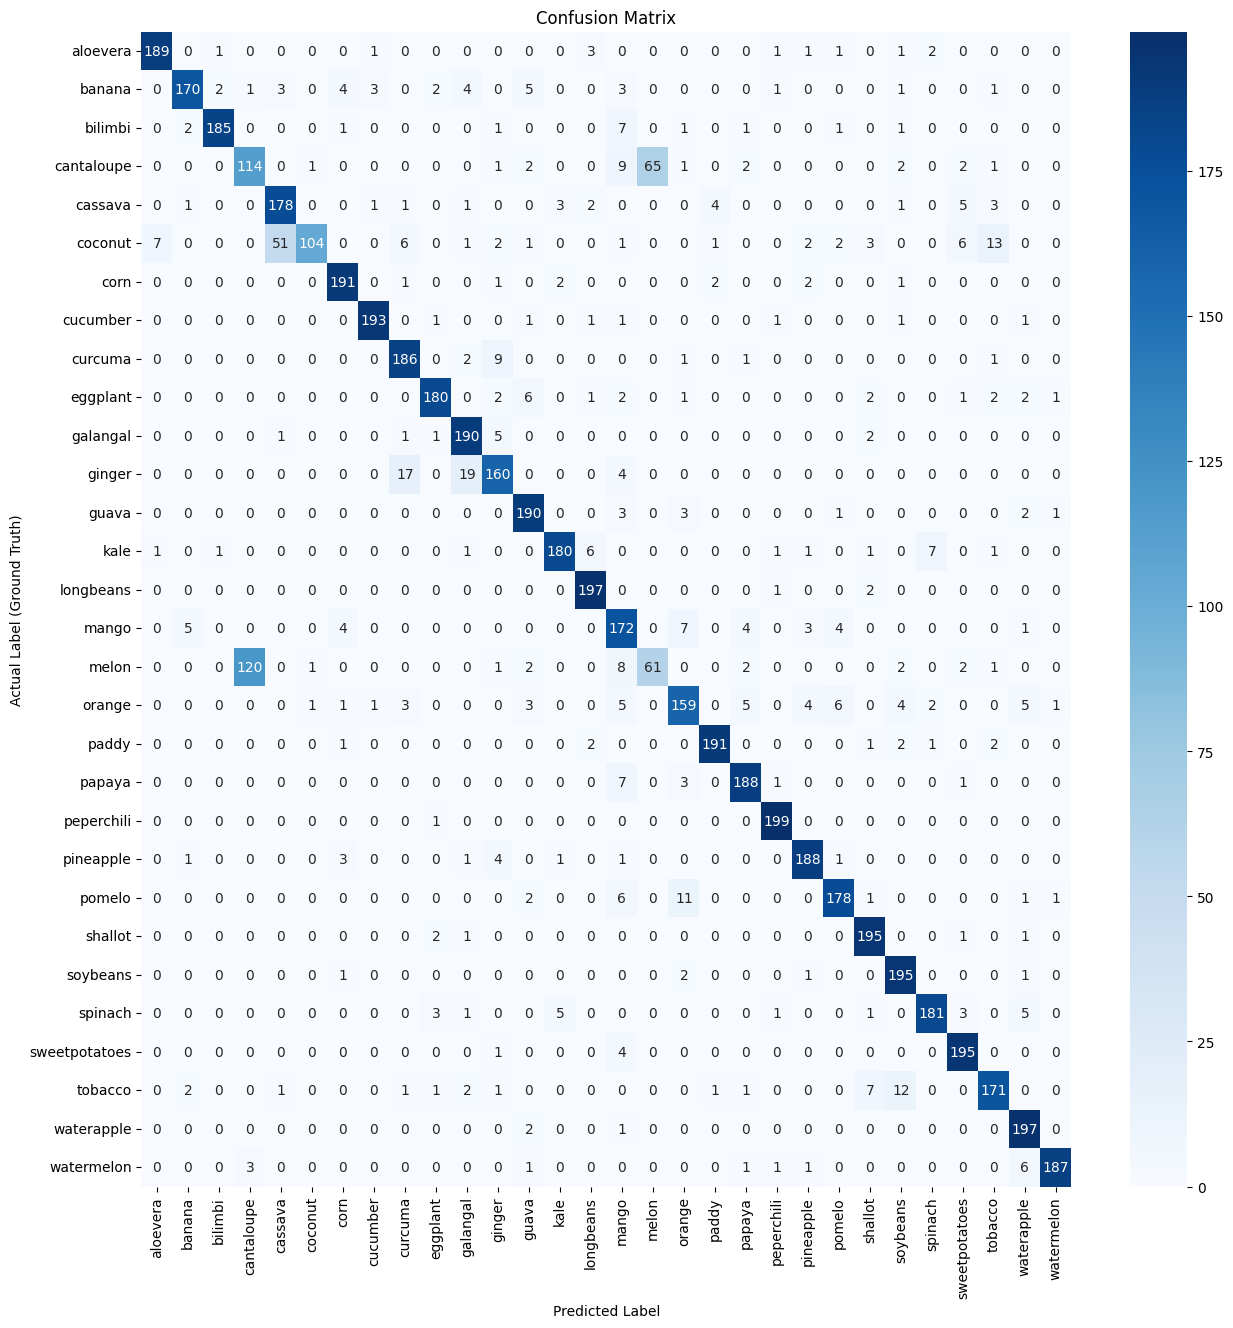

In [47]:
cm = confusion_matrix(y_true, y_pred)
# print("\nConfusion Matrix (Raw Counts):\n", cm)

# --- 6. Plot Confusion Matrix (Visualization) ---
plt.figure(figsize=(15, 15))
sns.heatmap(
    cm,
    annot=True,              # Show the numbers in each cell
    fmt='d',                 # Format as integers
    cmap='Blues',            # Use a nice color map
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label (Ground Truth)')
plt.xlabel('Predicted Label')
plt.show()